In [136]:
import cv2
import mediapipe as mp
import numpy as np
import os
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [99]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True)
labels = []
data = []

dataset_path = 'asl_dataset/'  # structure: dataset/A/*.jpg, dataset/B/*.jpg, etc.

I0000 00:00:1744558130.540247 8079479 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3 Pro


W0000 00:00:1744558130.549585 8145060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744558130.555274 8145060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [86]:
for label in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, label)
    if not os.path.isdir(class_path):
        continue
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        result = hands.process(img_rgb)

        keypoints = []
        if result.multi_hand_landmarks:
            for lm in result.multi_hand_landmarks[0].landmark:
                keypoints.extend([lm.x, lm.y, lm.z])
        else:
            keypoints = [0] * 63  # fill if no hand detected

        data.append(keypoints)
        labels.append(label)

hands.close()


In [100]:
########## new ###########

# Data Processing Improvements
for label in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, label)
    if not os.path.isdir(class_path):
        continue
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue  # skip if image not loaded properly
            
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        result = hands.process(img_rgb)

        keypoints = []
        if result.multi_hand_landmarks:
            for lm in result.multi_hand_landmarks[0].landmark:
                keypoints.extend([lm.x, lm.y, lm.z])
            # Normalize keypoints relative to wrist or palm base
            wrist_x, wrist_y = keypoints[0], keypoints[1]
            keypoints = [(kp - wrist_x if i % 3 == 0 else 
                         (kp - wrist_y if i % 3 == 1 else kp))
                         for i, kp in enumerate(keypoints)]
        else:
            continue  # Skip samples with no hand detected instead of filling with zeros

        data.append(keypoints)
        labels.append(label)

In [103]:
df = pd.DataFrame(data)
df['label'] = labels
df.to_csv('asl_keypoints.csv', index=False)

In [102]:

l = sorted(labels)
print(l)

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3',

In [ ]:
##Prepare the Data for Training

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [105]:
# Load the dataset
df = pd.read_csv('asl_keypoints.csv')

# Separate features and labels
X = df.drop('label', axis=1).values
y = df['label'].values

# Encode labels to integers (A=0, B=1, ..., Z=25)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)


In [127]:
# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

Sample landmarks: [ 0.00000000e+00  0.00000000e+00  1.20776076e-06  1.05683863e-01
 -7.86211491e-02 -8.98102969e-02  1.35555625e-01 -2.59341478e-01
 -1.09253205e-01  1.79373920e-02 -3.79350752e-01 -1.10604376e-01
 -1.05913669e-01 -4.11135226e-01 -1.12576313e-01  1.46381319e-01
 -4.08232242e-01 -4.99745682e-02  2.00290859e-01 -5.78191161e-01
 -7.43538514e-02  2.33813345e-01 -6.82982326e-01 -9.93151367e-02
  2.54908502e-01 -7.73733020e-01 -1.20344810e-01  3.77688706e-02
 -4.22331005e-01 -3.72309424e-02  3.39174271e-02 -6.14968508e-01
 -5.88685647e-02  3.09057236e-02 -7.26862058e-01 -8.58005211e-02
  2.51314342e-02 -8.18856519e-01 -1.02102920e-01 -5.16085923e-02
 -3.94989938e-01 -3.39888558e-02 -9.83162522e-02 -5.71859181e-01
 -9.42782238e-02 -1.17139310e-01 -6.84678346e-01 -1.46950096e-01
 -1.35234863e-01 -7.81743392e-01 -1.77918449e-01 -1.27685219e-01
 -3.31984162e-01 -3.45623903e-02 -1.43965095e-01 -4.38485563e-01
 -1.10063277e-01 -1.13818616e-01 -3.77237886e-01 -1.26031876e-01
 -8.870

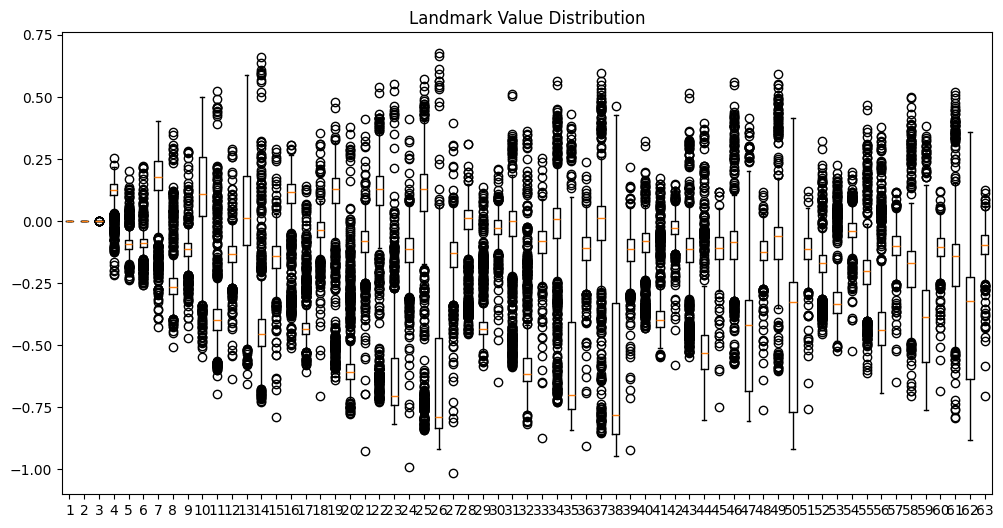

In [164]:
# Check sample from your training data
sample_idx = 0  # Try different indices
print("Sample landmarks:", X_train[sample_idx])
print("Should be class:", y_train[sample_idx])
print("Label:", labels[np.argmax(y_train[sample_idx])])

# Visualize landmark distribution
plt.figure(figsize=(12,6))
plt.title("Landmark Value Distribution")
plt.boxplot(X_train)
plt.show()

In [ ]:
######### new ##########

# Identify classes with too few samples
class_counts = np.bincount(y_train_labels)
too_few = np.where(class_counts < 6)[0]  # Classes with <6 samples

# Remove these classes
mask = ~np.isin(y_train_labels, too_few)
X_train_filtered = X_train[mask]
y_train_filtered = y_train_labels[mask]

# Now apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_filtered, y_train_filtered)
y_train_balanced = to_categorical(y_train_balanced)

In [123]:
print(y_train.shape)  # This should be (num_samples, 36)


(1298, 36)


In [124]:
y_labels = np.argmax(y_train, axis=1)
print("Label distribution:\n", pd.Series(y_labels).value_counts())

Label distribution:
 21    57
13    57
15    56
9     56
4     56
5     56
3     55
11    54
20    53
7     49
30    48
8     47
35    44
1     43
27    43
18    42
32    42
25    41
31    40
16    40
6     38
2     38
17    37
33    36
34    31
12    27
0     23
14    17
24    15
10    13
26    11
19    11
23     8
28     8
22     5
29     1
Name: count, dtype: int64


In [ ]:
##Build and Train the Model

In [132]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam 

In [37]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(63,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_encoded)), activation='softmax')  # number of classes
])


In [166]:
##### New #############
# Model Improvements
import tensorflow as tf
from tensorflow.keras import layers, optimizers

def build_proper_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model




In [74]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [168]:
####### new ###############

# Use focal loss to handle class imbalance


# Reinitialize
proper_model = build_proper_model((63,), len(labels))
proper_model.summary()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,292 (313.64 KB)

 Trainable params: 79,524 (310.64 KB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
history = model.fit(X_train, y_train, epochs=5000, validation_data=(X_val, y_val))

In [170]:
from sklearn.utils import class_weight
import numpy as np

# 1. Calculate proper class weights
y_train_labels = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced',
                                                classes=np.unique(y_train_labels),
                                                y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))

# 2. Training with correct class weights
history = proper_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weights_dict  # Proper class weights
)

Epoch 1/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1415 - loss: 3.5854 - val_accuracy: 0.1908 - val_loss: 3.4034 - learning_rate: 0.0010
Epoch 2/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6270 - loss: 1.6360 - val_accuracy: 0.1938 - val_loss: 3.1857 - learning_rate: 0.0010
Epoch 3/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7515 - loss: 1.0358 - val_accuracy: 0.0892 - val_loss: 2.9341 - learning_rate: 0.0010
Epoch 4/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8144 - loss: 0.6966 - val_accuracy: 0.1415 - val_loss: 2.6673 - learning_rate: 0.0010
Epoch 5/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8208 - loss: 0.6055 - val_accuracy: 0.1754 - val_loss: 2.4615 - learning_rate: 0.0010
Epoch 6/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8382 - loss: 0.5620 - val_accuracy: 0.3569 - val_loss: 2.0840 - learning_rate: 0.0010
Epoch 7/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8690 - loss: 0.4640 - val_acc

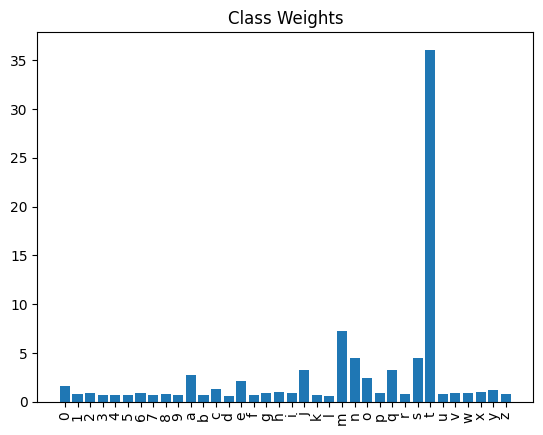

In [175]:
import matplotlib.pyplot as plt
plt.bar(range(len(class_weights)), class_weights)
plt.xticks(range(len(labels)), labels, rotation=90)
plt.title("Class Weights")
plt.show()

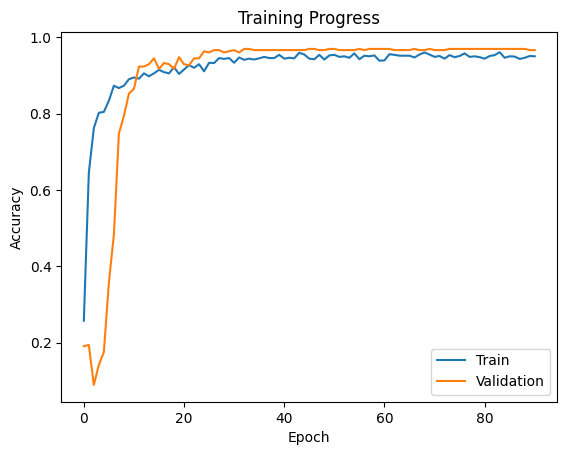

In [176]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [177]:
print("Input shape:", X_train.shape)
print("Label shape:", y_train.shape)
print("NaN values in X:", np.isnan(X_train).sum())
print("NaN values in y:", np.isnan(y_train).sum())

Input shape: (1298, 63)
Label shape: (1298, 36)
NaN values in X: 0
NaN values in y: 0


In [178]:
# Try overfitting a small batch
small_X = X_train[:100]
small_y = y_train[:100]
proper_model.fit(small_X, small_y, epochs=50, verbose=1)
# Should reach ~100% accuracy

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9632 - loss: 0.1081  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9367 - loss: 0.1769
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9444 - loss: 0.1264
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9715 - loss: 0.1121
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9385 - loss: 0.1352
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9498 - loss: 0.1584
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9498 - loss: 0.1249
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9383 - loss: 0.1596
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9415 - loss: 0.1297
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9303 - loss: 0.1610
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9746 - loss: 0.0994 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9498 - loss: 0.1267
Epoch 13/5

In [ ]:
# Save the best version after training
proper_model.save('final_asl_model.keras')

# Save class labels
import pickle
with open('class_labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

: 

In [179]:
####### new #########

import pickle

model.save('asl_model.keras')
with open('label_encoder_new.pkl', 'wb') as f:
    pickle.dump(le, f)

In [180]:
######### new ###########


# Convert history to dataframe and save
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)

In [143]:
import joblib

model.save('asl_mediapipe_model.h5')
joblib.dump(le, 'label_encoder.pkl')  # save label encoder for decoding predictions


['label_encoder.pkl']

In [ ]:
##real time testing

In [ ]:
####### new ##############

from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fn(y_true, y_pred):
        import tensorflow as tf
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1-y_pred)
        return -tf.reduce_mean(alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt + 1e-8))
    return focal_loss_fn

# Then load the model with custom_objects
model = load_model('asl_model.keras', 
                         custom_objects={'focal_loss_fn': focal_loss()})

In [ ]:
######## new #############

# Load the label encoder
with open('label_encoder.pkl', 'rb') as f:
    loaded_le = pickle.load(f)

# Example prediction
def predict_asl_sign(landmarks):
    """Predict ASL sign from hand landmarks"""
    landmarks = np.array(landmarks).reshape(1, -1)
    preds = loaded_model.predict(landmarks)
    pred_class = loaded_le.inverse_transform([np.argmax(preds)])
    confidence = np.max(preds)
    return pred_class[0], confidence

# Label map (make sure this matches your label encoding)
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [153]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model

In [ ]:
model = load_model('asl_model.keras')

# Label map (make sure this matches your label encoding)
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [161]:
# Initialize MediaPipe
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def extract_keypoints(results):
    if results.right_hand_landmarks:
        rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
        if rh.shape[0] == 63:
            return rh
    elif results.left_hand_landmarks:
        lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()
        if lh.shape[0] == 63:
            return lh
    return np.zeros(63)


In [162]:
# Start webcam
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as holistic:

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Flip for natural selfie view
        frame = cv2.flip(frame, 1)

        # Convert to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make detection
        results = holistic.process(image)

        # Convert back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw landmarks
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

        # Extract keypoints
        keypoints = extract_keypoints(results)

        if np.any(keypoints):
            prediction = model.predict(np.expand_dims(keypoints, axis=0), verbose=0)
            pred_label = labels[np.argmax(prediction)]

            # Display prediction
            cv2.putText(image, f'Sign: {pred_label}', (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3, cv2.LINE_AA)

        # Show the image
        cv2.imshow('ASL Live Test', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1744562695.678215 8079479 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3 Pro
W0000 00:00:1744562695.750686 8205981 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744562695.767782 8205987 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744562695.772348 8205981 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744562695.772497 8205985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744562695.776250 8205989 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

In [34]:
print("Prediction vector:", prediction)

Prediction vector: [[1.2638858e-02 3.3115668e-06 5.2484544e-04 1.4918922e-07 4.2701857e-05
  3.8736302e-06 1.8947651e-03 8.7699016e-07 9.3676186e-05 5.2808534e-04
  1.0314094e-02 1.1010358e-05 9.0027126e-05 1.2396882e-05 1.7331037e-04
  8.9254021e-04 1.2651213e-01 2.4989215e-05 2.3446232e-03 2.6025332e-04
  2.3271170e-05 8.6841785e-05 1.2150152e-02 2.3959784e-03 1.5688617e-03
  2.7314492e-03 7.8476572e-01 3.4332444e-04 8.9926987e-05 2.5051599e-04
  9.4399948e-06 1.4091942e-04 3.7543695e-02 1.1284971e-05 1.2283026e-03
  2.9372299e-04]]


In [35]:
print("Top 3 predictions:")
top_indices = prediction[0].argsort()[-3:][::-1]
for i in top_indices:
    print(f"Index {i} = {labels[i]} → {prediction[0][i]:.4f}")

Top 3 predictions:
Index 26 = q → 0.7848
Index 16 = g → 0.1265
Index 32 = w → 0.0375
